In [ ]:
# Install package first
# We use uv for faster installation
!pip install uv
!uv pip install -q autogluon.timeseries --system
!uv pip uninstall -q torchaudio torchvision torchtext --system # fix incompatible package versions on Colab

## if there seems to be inconsistency due to numpy & pandas versions, do the following
!uv pip uninstall pandas numpy
!uv pip install -q --force-reinstall numpy==1.26.4 --system
!uv pip install -q --force-reinstall pandas==2.2.2 --system
## You may need to restart colab kernel

Using Python 3.11.11 environment at: /usr
Uninstalled 2 packages in 183ms
 - numpy==1.26.4
 - pandas==2.2.2


In [ ]:
!pip install -U langchain-openai langgraph

In [ ]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/GE_Capstone/AI Agent Workflow/

/content/drive/MyDrive/GE_Capstone/AI Agent Workflow


In [ ]:
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.runnables import Runnable
from langchain_core.runnables import RunnableConfig
from langchain_core.agents import AgentFinish
from langgraph.graph.message import add_messages

from langgraph.types import Command
from langchain.chat_models import init_chat_model
import os, getpass
from typing import Literal, Annotated
import json

### define workflow graph

In [ ]:
# Set OpenAI API Key
if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

# Initialize GPT-4 model
llm = init_chat_model("gpt-4o", model_provider="openai")
# llm = init_chat_model("gpt-4o-mini", model_provider="openai")
# llm = init_chat_model("gpt-3.5-turbo", model_provider="openai")

In [ ]:
# Natural language supervisor: determines task type
def llm_supervisor_node(state: MessagesState) -> Command[Literal["chronos_preprocess"]]:
    last_message = state["messages"][-1]
    llm = init_chat_model("gpt-3.5-turbo", model_provider="openai")
    system_msg = SystemMessage(content=(
        "You are a task router for time series forecasting tasks.\n"
        "You must ONLY reply with a strict JSON like this:\n"
        '{"task": "forecast", "params": {"prediction_length": 14, "file_path": "data.csv"}}\n'
        "Valid tasks: 'forecast', 'threshold_exceedance', 'slope_calculation'.\n"
        "DO NOT add any explanation or markdown formatting."
    ))

    response = llm.invoke([system_msg, last_message])
    print("LLM raw content:", response.content)

    try:
        task_payload = json.loads(response.content)
        task_alias = {
            "forecast": "forecast",
            "threshold exceedance": "threshold_exceedance",
            "threshold_exceedance": "threshold_exceedance",
            "slope calculation": "slope_calculation",
            "slope_calculation": "slope_calculation"
        }
        raw_task = task_payload.get("task", "").strip().lower()
        standard_task = task_alias.get(raw_task)
        if not standard_task:
            raise ValueError(f"Unknown task: {raw_task}")
        task_payload["task"] = standard_task
        assert "task" in task_payload and "params" in task_payload
        assert "file_path" in task_payload["params"] and "prediction_length" in task_payload["params"]
    except Exception as e:
        raise ValueError(f"Invalid LLM response: {response.content}") from e

    routed_msg = HumanMessage(content=json.dumps(task_payload), name="supervisor")
    return Command(update={"messages": state["messages"] + [routed_msg]}, goto="chronos_preprocess")

In [ ]:
# Data preprocessing: extract file and prediction length
def chronos_preprocess_node(state: MessagesState) -> Command[Literal["chronos_predict"]]:
    supervisor_msg = next(m for m in reversed(state["messages"]) if m.name == "supervisor")
    task_data = json.loads(supervisor_msg.content)
    params = task_data["params"]
    file_path = params["file_path"]
    pred_len = params["prediction_length"]

    df = pd.read_csv(file_path)
    df = df[["item_id", "timestamp", "target"]]
    data_dict = df.to_dict(orient="list")
    content = json.dumps({
        "prediction_length": pred_len,
        "data": data_dict
    })
    new_messages = state["messages"] + [HumanMessage(content=content, name="preprocessor")]
    return Command(update={"messages": new_messages}, goto="chronos_predict")

# Define the prediction node that trains a model using AutoGluon (Chronos) and outputs the top model and MAPE
def chronos_predict_node(state: MessagesState) -> Command[Literal["postprocess_router"]]:
    last_message = state["messages"][-1]
    content = json.loads(last_message.content)
    pred_len = content["prediction_length"]
    data_dict = content["data"]
    df = pd.DataFrame(data_dict)

    tsdf = TimeSeriesDataFrame.from_data_frame(df, id_column="item_id", timestamp_column="timestamp")
    train_data, test_data = tsdf.train_test_split(pred_len)
    predictor = TimeSeriesPredictor(prediction_length=pred_len).fit(train_data, presets="bolt_small")
    predictions = predictor.predict(train_data)

    leaderboard = predictor.leaderboard(test_data)
    top_model = leaderboard.iloc[0]["model"]
    mape = -leaderboard.iloc[0]["score_test"]

    predictions_df = predictions.to_data_frame().reset_index()
    predictions_df["timestamp"] = predictions_df["timestamp"].astype(str)
    predictions_dict = predictions_df.to_dict(orient="list")

    payload = {
        "prediction_length": pred_len,
        "data": data_dict,
        "predictions": predictions_dict,
        "model": top_model,
        "mape": mape
    }

    new_messages = state["messages"] + [HumanMessage(content=json.dumps(payload), name="predictor")]
    return Command(update={"messages": new_messages}, goto="postprocess_router")

In [ ]:
# Postprocess routing
def postprocess_router(state: MessagesState) -> Command[str]:
    for msg in reversed(state["messages"]):
        if msg.name == "supervisor":
            task = json.loads(msg.content)["task"]
            if task == "forecast":
                return Command(update={}, goto="forecast_result")
            elif task == "threshold_exceedance":
                return Command(update={}, goto="threshold_eval")
            elif task == "slope_calculation":
                return Command(update={}, goto="slope_eval")
    raise ValueError("No task found in message state.")

In [ ]:
# Return raw prediction output
def forecast_result_node(state: MessagesState) -> Command[Literal[END]]:
    payload = json.loads(state["messages"][-1].content)
    model = payload["model"]
    mape = payload["mape"]
    predictions = payload["predictions"]
    message = f"Top model: {model}, MAPE: {mape * 100:.2f}%\nPredictions (mean):\n"

    df = pd.DataFrame(predictions)
    mean_df = df[["item_id", "timestamp", "mean"]]
    preview = mean_df.tail(10).to_string(index=False)

    return Command(update={"messages": state["messages"] + [AIMessage(content=message + preview)]}, goto=END)

In [ ]:
# Threshold exceedance accuracy evaluation
def threshold_eval_node(state: MessagesState) -> Command[Literal[END]]:
    payload = json.loads(state["messages"][-1].content)
    df = pd.DataFrame(payload["data"])
    predictions_df = pd.DataFrame(payload["predictions"])

    df["timestamp"] = pd.to_datetime(df["timestamp"])
    predictions_df["timestamp"] = pd.to_datetime(predictions_df["timestamp"])
    df["item_id"] = df["item_id"].astype(str)
    predictions_df["item_id"] = predictions_df["item_id"].astype(str)

    df["timestamp"] = df["timestamp"].dt.strftime("%Y-%m-%d")
    predictions_df["timestamp"] = predictions_df["timestamp"].dt.strftime("%Y-%m-%d")

    merged = pd.merge(predictions_df, df, on=["item_id", "timestamp"])
    if merged.empty:
        result = "Error: No overlapping timestamps found between prediction and ground truth."
        return Command(update={"messages": state["messages"] + [AIMessage(content=result)]}, goto=END)

    merged = merged.rename(columns={"target": "y1", "mean": "yhat1"})

    mean_val = merged["y1"].mean()
    std_val = merged["y1"].std()
    threshold = mean_val + 2 * std_val

    predicted_exceed = merged["yhat1"] > threshold
    actual_exceed = merged["y1"] > threshold
    acc = accuracy_score(actual_exceed, predicted_exceed)

    result = f"Threshold: {threshold:.2f}, Exceedance accuracy: {acc*100:.2f}%"
    return Command(update={"messages": state["messages"] + [AIMessage(content=result)]}, goto=END)

In [ ]:
# Slope error metrics evaluation
def slope_eval_node(state: MessagesState) -> Command[Literal[END]]:
    payload = json.loads(state["messages"][-1].content)
    df = pd.DataFrame(payload["data"])
    pred_len = payload["prediction_length"]
    predictions_df = pd.DataFrame(payload["predictions"])
    tsdf = TimeSeriesDataFrame.from_data_frame(df, id_column="item_id", timestamp_column="timestamp")
    _, test_data = tsdf.train_test_split(pred_len)
    actual = pd.DataFrame(test_data).reset_index()
    actual["timestamp"] = pd.to_datetime(actual["timestamp"]).dt.strftime("%Y-%m-%d")
    predicted = predictions_df.rename(columns={"mean": "yhat1"}).reset_index()
    merged = pd.merge(predicted, actual, on=["item_id", "timestamp"])
    merged = merged.rename(columns={"target": "y1"})
    x = np.arange(len(merged))
    slope_yhat, _ = np.polyfit(x, merged["yhat1"], 1)
    slope_y, _ = np.polyfit(x, merged["y1"], 1)
    mse = mean_squared_error([slope_y], [slope_yhat])
    mae = mean_absolute_error([slope_y], [slope_yhat])
    result = f"True slope: {slope_y:.4f}, Predicted slope: {slope_yhat:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}"
    return Command(update={"messages": state["messages"] + [AIMessage(content=result)]}, goto=END)

In [ ]:
# Build the graph
builder = StateGraph(MessagesState)
builder.add_node("llm_supervisor", llm_supervisor_node)
builder.add_node("chronos_preprocess", chronos_preprocess_node)
builder.add_node("chronos_predict", chronos_predict_node)
builder.add_node("postprocess_router", postprocess_router)
builder.add_node("forecast_result", forecast_result_node)
builder.add_node("threshold_eval", threshold_eval_node)
builder.add_node("slope_eval", slope_eval_node)
builder.set_entry_point("llm_supervisor")
builder.add_edge("llm_supervisor", "chronos_preprocess")
builder.add_edge("chronos_preprocess", "chronos_predict")
# builder.add_conditional_edges("chronos_predict", postprocess_router, {
#     "forecast_result": "forecast_result",
#     "threshold_eval": "threshold_eval",
#     "slope_eval": "slope_eval"
# })
builder.add_edge("chronos_predict", "postprocess_router")
builder.add_edge("forecast_result", END)
builder.add_edge("threshold_eval", END)
builder.add_edge("slope_eval", END)
graph = builder.compile()

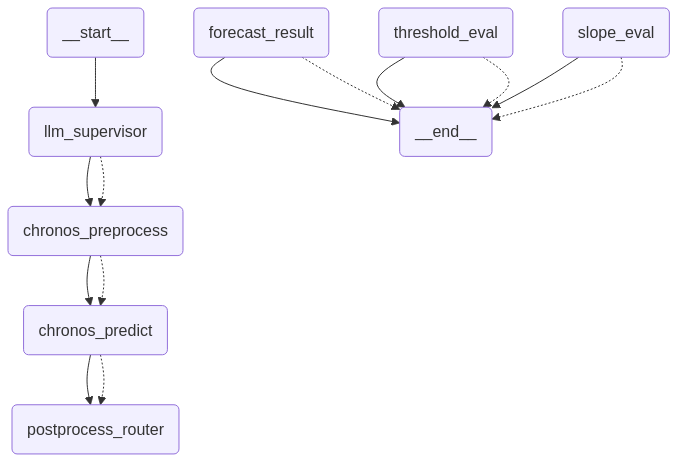

In [ ]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

### run the graph

In [ ]:
def initialize_state(prompt: str):
    return {"messages": [HumanMessage(content=prompt)]}

In [ ]:
# forecast
state = initialize_state("Please forecast the next 24 days using the file 'reform_WineDataset_DARTS_176.csv'.")
output = graph.invoke(state)
for msg in output["messages"]:
    print(f"[{msg.type}] {msg.content}")

Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/AI Agent Workflow/AutogluonModels/ag-20250331_210227'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.24 GB / 12.67 GB (80.8%)
Disk Space Avail:   61.48 GB / 107.72 GB (57.1%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series fr

LLM raw content: {"task": "forecast", "params": {"prediction_length": 24, "file_path": "reform_WineDataset_DARTS_176.csv"}}


Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.06 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


[human] Please forecast the next 24 days using the file 'reform_WineDataset_DARTS_176.csv'.
[human] {"task": "forecast", "params": {"prediction_length": 24, "file_path": "reform_WineDataset_DARTS_176.csv"}}
[human] {"prediction_length": 24, "data": {"item_id": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], "timestamp": ["1980-01-01 00:00:00", "1980-02-01 00:00:00", "1980-03-01 00:00:00", "1980-04-01 00:00:00", "1980-05-01 00:00:00", "1980-06-01 00:00:00", "1980-07-01 00:00:00", "1980-08-01 00:00:00", "1980-09-01

In [ ]:
# threshold
state = initialize_state("Using the file 'reform_WineDataset_DARTS_176.csv', evaluate threshold exceedance detection accuracy after forecasting the next 24 steps.")
output = graph.invoke(state)
for msg in output["messages"]:
    print(f"[{msg.type}] {msg.content}")

Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/AI Agent Workflow/AutogluonModels/ag-20250331_210246'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.23 GB / 12.67 GB (80.7%)
Disk Space Avail:   61.48 GB / 107.72 GB (57.1%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series fr

LLM raw content: {"task": "threshold_exceedance", "params": {"prediction_length": 24, "file_path": "reform_WineDataset_DARTS_176.csv"}}


Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.05 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


[human] Using the file 'reform_WineDataset_DARTS_176.csv', evaluate threshold exceedance detection accuracy after forecasting the next 24 steps.
[human] {"task": "threshold_exceedance", "params": {"prediction_length": 24, "file_path": "reform_WineDataset_DARTS_176.csv"}}
[human] {"prediction_length": 24, "data": {"item_id": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], "timestamp": ["1980-01-01 00:00:00", "1980-02-01 00:00:00", "1980-03-01 00:00:00", "1980-04-01 00:00:00", "1980-05-01 00:00:00", "1980-06-01 00:

In [ ]:
# slope
state = initialize_state("Use the file 'reform_WineDataset_DARTS_176.csv' to perform slope calculation evaluation after forecasting the next 24 steps.")
output = graph.invoke(state)
for msg in output["messages"]:
    print(f"[{msg.type}] {msg.content}")

Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/AI Agent Workflow/AutogluonModels/ag-20250331_210438'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.25 GB / 12.67 GB (80.9%)
Disk Space Avail:   61.47 GB / 107.72 GB (57.1%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series fr

LLM raw content: {"task": "slope_calculation", "params": {"file_path": "reform_WineDataset_DARTS_176.csv", "prediction_length": 24}}


Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.06 s
Best model: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


[human] Use the file 'reform_WineDataset_DARTS_176.csv' to perform slope calculation evaluation after forecasting the next 24 steps.
[human] {"task": "slope_calculation", "params": {"file_path": "reform_WineDataset_DARTS_176.csv", "prediction_length": 24}}
[human] {"prediction_length": 24, "data": {"item_id": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], "timestamp": ["1980-01-01 00:00:00", "1980-02-01 00:00:00", "1980-03-01 00:00:00", "1980-04-01 00:00:00", "1980-05-01 00:00:00", "1980-06-01 00:00:00", "1980-0